In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib.ticker import MultipleLocator

# Import dataframe

In [2]:
#df = pd.read_pickle("df_20250505_114353")
#df = pd.read_pickle("df_20250506_145216")
#df_ma = pd.read_pickle("df_20250507_111542") # weighted
df_ma = pd.read_pickle("df_ma_800_100_20250511_170531") # weighted
#df_null = pd.read_pickle("df_null_20250507_141749") # weighted
df_null = pd.read_pickle("df_null_20250511_171357") # weighted


In [3]:
def get_masks(df):
    en350 = (df.energy == 350) & (df.Lnum_labels == 1)
    en300 = (df.energy == 300) & (df.Lnum_labels == 1)
    en250 = (df.energy == 250) & (df.Lnum_labels == 1)
    en200 = (df.energy == 200) & (df.Lnum_labels == 1)
    en150 = (df.energy == 150) & (df.Lnum_labels == 1)
    en100 = (df.energy == 100) & (df.Lnum_labels == 1)
    en80 = (df.energy == 80) & (df.Lnum_labels == 1)
    en60 = (df.energy == 60) & (df.Lnum_labels == 1)
    en40 = (df.energy == 40) & (df.Lnum_labels == 1)
    en20 = (df.energy == 20) & (df.Lnum_labels == 1)
    en10 = (df.energy == 10) & (df.Lnum_labels == 1)
    enmasks = [en350, en300, en250, en200, en150, en100, en80, en60, en40, en20, en10]
    return enmasks

def rices_rule(arr):
    """
    Rule for choosing bin size I want to try.
    Cube root times 2.
    https://www.statisticshowto.com/choose-bin-sizes-statistics/#choose
    """
    return np.round((len(arr))**(1/3)*2, 0).astype(int)

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def lin(x,m,b):
    return m*x + b

def fit_gaussian(arr):
    """
    Gaussian fit using iminuit and a least squares loss function.
    """

    def least_squares(A, mu, sigma):
        predicted = gaussian(x_data, A, mu, sigma)
        return np.sum((y_data - predicted)**2)
    
    Nbins = rices_rule(arr)
    hist, bins = np.histogram(arr, bins=Nbins)
    bin_centers = bins[:-1] + np.diff(bins) / 2
    x_data = bin_centers
    y_data = hist
    m = Minuit(least_squares, A=y_data.max(), mu=arr.mean(), sigma=arr.std())
    m.migrad()  # Perform the minimization
    m.hesse()   # Estimate the uncertainties

    fit_amplitude = m.values['A']
    fit_mean = m.values['mu']
    fit_sigma = m.values['sigma']
    
    return (fit_amplitude, fit_mean, fit_sigma)

def fit_gaussian_all(frame, masks):
    fits = [None]*len(masks)
    for i,m in enumerate(masks):
        energy = frame[m].energy.mean().astype(int)
        fits[i] = list(fit_gaussian(frame[m].Ladc_sum))
        fits[i].append(energy)
    return np.array(fits)

def linear_fit(x,y):
    def least_squares(m, b):
        predicted = lin(x_data, m, b)
        return np.sum((y_data - predicted)**2)
    x_data = x
    y_data = y
    m_guess = y[0] - y[1]/(x[0] - x[1])
    m = Minuit(least_squares, m=m_guess, b=0)
    m.migrad()  # Perform the minimization
    m.hesse()   # Estimate the uncertainties
    fit_slope = m.values['m']
    fit_intersection = m.values['b']
    return fit_slope, fit_intersection

def lin_inv(y, m, b):
    return (y-b)/m

In [4]:
def lst_len(lst):
    return len(lst)

def eng_avg(engs):
    return np.array(engs).mean().astype(int)

def eng_adc_rec_avg(cols):
    adc = cols.Ladc_sum
    m = cols.m
    b = cols.b
    return lin_inv(adc, m, b)

def eng_cl_rec_avg(cols):
    cluster_sums = cols.Lcluster_sums
    if len(cluster_sums) == 0:
        return 0
    m = cols.m
    b = cols.b
    labels = cols.Lnum_labels
    cluster_eng = [lin_inv(c, m, b) for c in cluster_sums]
    return np.mean(cluster_eng)

def add_energy_reconstruction(df):
    df["energy"] = df.Lenergies.apply(eng_avg)
    g_fit = fit_gaussian_all(df, get_masks(df))
    l_fit = linear_fit(g_fit[:,3], g_fit[:,1])
    df["m"] = l_fit[0]
    df["b"] = l_fit[1]
    #df["eng_adc_rec_avg"] = df.apply(eng_adc_rec_avg, axis=1)
    df["eng_cl_rec_avg"] = df.apply(eng_cl_rec_avg, axis=1)

In [5]:
add_energy_reconstruction(df_ma)

In [6]:
add_energy_reconstruction(df_null)

In [7]:
df_null

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,Lcluster_sums,energy,m,b,eng_cl_rec_avg
0,"[[-4.509516340751861, 3.0383975001125454]]",1.0,1.0,1.0,1.0,-1.000000,23494.0,1.0,1.0,[350.0],[23494.0],350,226.672908,6311.893192,75.801325
1,"[[-6.3023217813856025, 0.02722564515785644]]",1.0,1.0,1.0,1.0,-1.000000,77766.0,1.0,7.0,[350.0],[77766.0],350,226.672908,6311.893192,315.230027
2,"[[0.8183251463982363, 2.4213109898164835]]",1.0,1.0,1.0,1.0,-1.000000,86063.0,1.0,4.0,[350.0],[86063.0],350,226.672908,6311.893192,351.833431
3,"[[-3.3581115339969596, -4.672998570954047]]",1.0,1.0,1.0,1.0,-1.000000,81320.0,1.0,5.0,[350.0],[81320.0],350,226.672908,6311.893192,330.909007
4,"[[-2.6121692604904014, -1.3380434027806964]]",1.0,1.0,1.0,1.0,-1.000000,45723.0,1.0,3.0,[350.0],[45723.0],350,226.672908,6311.893192,173.867743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,"[[-3.190941809090787, -3.6875041422346357], [1...",0.1,0.0,0.0,1.0,6.082817,30450.0,10.0,0.0,[10.0],[30450.0],10,226.672908,6311.893192,106.488716
6596,"[[-3.190941809090787, -3.6875041422346357], [-...",0.1,0.0,0.0,1.0,6.185407,31141.0,10.0,0.0,[10.0],[31141.0],10,226.672908,6311.893192,109.537161
6597,"[[-3.190941809090787, -3.6875041422346357], [-...",0.1,0.0,0.0,1.0,5.847040,31877.0,10.0,0.0,[10.0],[31877.0],10,226.672908,6311.893192,112.784131
6598,"[[-3.190941809090787, -3.6875041422346357], [0...",0.1,0.0,0.0,1.0,5.110471,34015.0,10.0,0.0,[10.0],[34015.0],10,226.672908,6311.893192,122.216224


In [8]:
df_ma

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,Lcluster_sums,energy,m,b,eng_cl_rec_avg
0,"[[-4.509516340751861, 3.0383975001125454]]",2.0,0.000000,1.000000,0.000000,-1.000000,23494.0,1.0,1.0,[350.0],"[13597.0, 6661.0]",350,226.672908,6311.893192,16.839713
1,"[[-6.3023217813856025, 0.02722564515785644]]",2.0,0.000000,1.000000,0.000000,-1.000000,77766.0,1.0,7.0,[350.0],"[67395.0, 1657.0]",350,226.672908,6311.893192,124.470573
2,"[[0.8183251463982363, 2.4213109898164835]]",3.0,0.000000,1.000000,0.000000,-1.000000,86063.0,1.0,4.0,[350.0],"[74306.0, 1376.0, 1103.0]",350,226.672908,6311.893192,85.070188
3,"[[-3.3581115339969596, -4.672998570954047]]",1.0,0.000000,1.000000,0.000000,-1.000000,81320.0,1.0,5.0,[350.0],[72929.0],350,226.672908,6311.893192,293.890909
4,"[[-2.6121692604904014, -1.3380434027806964]]",1.0,0.000000,1.000000,0.000000,-1.000000,45723.0,1.0,3.0,[350.0],[39198.0],350,226.672908,6311.893192,145.081771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,"[[-3.190941809090787, -3.6875041422346357], [1...",0.0,0.000000,0.000000,1.000000,6.082817,30450.0,10.0,0.0,[10.0],[],10,226.672908,6311.893192,0.000000
6596,"[[-3.190941809090787, -3.6875041422346357], [-...",0.1,0.177943,0.112519,0.425139,6.185407,31141.0,10.0,0.0,[10.0],[9005.0],10,226.672908,6311.893192,11.881026
6597,"[[-3.190941809090787, -3.6875041422346357], [-...",0.1,0.178854,0.113374,0.423377,5.847040,31877.0,10.0,0.0,[10.0],[9301.0],10,226.672908,6311.893192,13.186873
6598,"[[-3.190941809090787, -3.6875041422346357], [0...",0.3,0.255129,0.182911,0.421581,5.110471,34015.0,10.0,0.0,[10.0],"[13092.0, 1229.0, 1770.0]",10,226.672908,6311.893192,-4.183237


In [34]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size" : 15,
    "legend.fontsize" : 12,
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.major.size" : 5.0,
    "xtick.minor.size" : 3.0,
    "ytick.major.size" : 5.0,
    "ytick.minor.size" : 3.0,
    "axes.linewidth" : 0.8,
    "legend.handlelength" : 2,
})


#plt.rcParams['legend.handlelength'] = 5.0

def plot_chunks(x, y, Nbins, label, marker_shape=".", color="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    bins = np.linspace(min(x), max(x), Nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mu_y = np.zeros(Nbins)
    sigma_y = np.zeros(Nbins)
    
    for i in range(Nbins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            mu_y[i] = np.mean(y[mask])
            sigma_y[i] = np.std(y[mask]) / np.sqrt(np.sum(mask))

    if color == "":
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle='solid', capsize=5, label=label)
    else:
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle='solid', color=color, capsize=5, label=label)

def plot_performance_particle_num(df, x_col, y_col, marker_shape="^", linestyle="", color="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    grp = df.groupby(x_col)[y_col]
    mu_x = grp.mean().index
    mu_y = grp.mean().values
    sigma_y = grp.sem().values
    if color == "":
        ax.errorbar(mu_x, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, capsize=5)
    else:
        ax.errorbar(mu_x, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, color=color, capsize=5)
    #ax.plot(mu_x, mu_y)

def plot_ax(ax, x_label = "", y_label = ""):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.yaxis.set_ticks_position("both")
    ax.xaxis.set_ticks_position("both")
    ax.legend(framealpha=0)

In [10]:
df_ma

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,Lcluster_sums,energy,m,b,eng_cl_rec_avg
0,"[[-4.509516340751861, 3.0383975001125454]]",2.0,0.000000,1.000000,0.000000,-1.000000,23494.0,1.0,1.0,[350.0],"[13597.0, 6661.0]",350,226.672908,6311.893192,16.839713
1,"[[-6.3023217813856025, 0.02722564515785644]]",2.0,0.000000,1.000000,0.000000,-1.000000,77766.0,1.0,7.0,[350.0],"[67395.0, 1657.0]",350,226.672908,6311.893192,124.470573
2,"[[0.8183251463982363, 2.4213109898164835]]",3.0,0.000000,1.000000,0.000000,-1.000000,86063.0,1.0,4.0,[350.0],"[74306.0, 1376.0, 1103.0]",350,226.672908,6311.893192,85.070188
3,"[[-3.3581115339969596, -4.672998570954047]]",1.0,0.000000,1.000000,0.000000,-1.000000,81320.0,1.0,5.0,[350.0],[72929.0],350,226.672908,6311.893192,293.890909
4,"[[-2.6121692604904014, -1.3380434027806964]]",1.0,0.000000,1.000000,0.000000,-1.000000,45723.0,1.0,3.0,[350.0],[39198.0],350,226.672908,6311.893192,145.081771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,"[[-3.190941809090787, -3.6875041422346357], [1...",0.0,0.000000,0.000000,1.000000,6.082817,30450.0,10.0,0.0,[10.0],[],10,226.672908,6311.893192,0.000000
6596,"[[-3.190941809090787, -3.6875041422346357], [-...",0.1,0.177943,0.112519,0.425139,6.185407,31141.0,10.0,0.0,[10.0],[9005.0],10,226.672908,6311.893192,11.881026
6597,"[[-3.190941809090787, -3.6875041422346357], [-...",0.1,0.178854,0.113374,0.423377,5.847040,31877.0,10.0,0.0,[10.0],[9301.0],10,226.672908,6311.893192,13.186873
6598,"[[-3.190941809090787, -3.6875041422346357], [0...",0.3,0.255129,0.182911,0.421581,5.110471,34015.0,10.0,0.0,[10.0],"[13092.0, 1229.0, 1770.0]",10,226.672908,6311.893192,-4.183237


In [11]:
df_ma["eng_rec_eff"] = df_ma.eng_cl_rec_avg / df_ma.energy
df_null["eng_rec_eff"] = df_null.eng_cl_rec_avg / df_null.energy


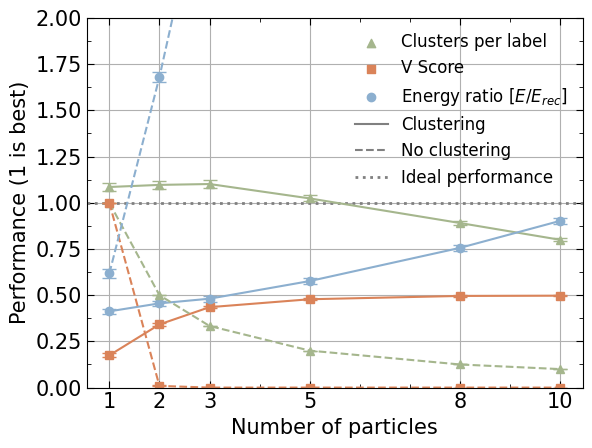

In [33]:
fig, ax = plt.subplots(1,1)
plot_performance_particle_num(df_ma, "Lnum_labels", "Lclusters_per_label", "^", "solid", "#a5b68dff", ax)
plot_performance_particle_num(df_ma, "Lnum_labels", "Lv_score", "s", "solid", "#da8359ff", ax)
#plot_performance_particle_num(df_ma, "Lnum_labels", "Lhomogeneity_score", "Cluster", "^", "solid", ax)
#plot_performance_particle_num(df_ma, "Lnum_labels", "Lcompleteness_score", "Cluster", "^", "solid", ax)
plot_performance_particle_num(df_ma, "Lnum_labels", "eng_rec_eff", "o", "solid", "#8cafcfff", ax)

ax.scatter([],[], label="Clusters per label", color="#a5b68dff", marker="^")
ax.scatter([],[], label="V Score", color="#da8359ff", marker="s")
ax.scatter([],[], label="Energy ratio [$E/E_{rec}$]", color="#8cafcfff", marker="o")

ax.plot([], label="Clustering", linestyle="solid", color="grey")
ax.plot([], label="No clustering", linestyle="dashed", color="grey")
ax.axhline(1, label="Ideal performance", linestyle="dotted", linewidth=2, color="grey")

plot_performance_particle_num(df_null, "Lnum_labels", "Lclusters_per_label", "^", "dashed", "#a5b68dff", ax)
plot_performance_particle_num(df_null, "Lnum_labels", "Lv_score", "s", "dashed", "#da8359ff", ax)
#plot_performance_particle_num(df_null, "Lnum_labels", "Lhomogeneity_score", "Null", "s", "dashed", ax)
plot_performance_particle_num(df_null, "Lnum_labels", "eng_rec_eff", "o", "dashed", "#8cafcfff", ax)
#plot_performance_particle_num(df_null, "Lnum_labels", "Lcompleteness_score", "Null", "s", "dashed", ax)
plot_ax(ax)
ax.set_xlabel("Number of particles")
ax.set_ylabel("Performance (1 is best)")
ax.set_xticks([1,2,3,5,8,10], ["1","2","3","5","8","10"])
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.125))
ax.set_ylim(0,2)
fig.savefig("performance_labels.pdf", bbox_inches="tight", transparent=True)

In [52]:
df_null[(df_null.Lnum_labels <= 1) & (df_null.energy == 350)]

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,Lcluster_sums,energy,m,b,eng_cl_rec_avg,eng_rec_eff
0,"[[-4.509516340751861, 3.0383975001125454]]",1.0,1.0,1.0,1.0,-1.0,23494.0,1.0,1.0,[350.0],[23494.0],350,226.672908,6311.893192,75.801325,0.216575
1,"[[-6.3023217813856025, 0.02722564515785644]]",1.0,1.0,1.0,1.0,-1.0,77766.0,1.0,7.0,[350.0],[77766.0],350,226.672908,6311.893192,315.230027,0.900657
2,"[[0.8183251463982363, 2.4213109898164835]]",1.0,1.0,1.0,1.0,-1.0,86063.0,1.0,4.0,[350.0],[86063.0],350,226.672908,6311.893192,351.833431,1.005238
3,"[[-3.3581115339969596, -4.672998570954047]]",1.0,1.0,1.0,1.0,-1.0,81320.0,1.0,5.0,[350.0],[81320.0],350,226.672908,6311.893192,330.909007,0.945454
4,"[[-2.6121692604904014, -1.3380434027806964]]",1.0,1.0,1.0,1.0,-1.0,45723.0,1.0,3.0,[350.0],[45723.0],350,226.672908,6311.893192,173.867743,0.496765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[[-5.335323848266053, -3.969768913539276]]",1.0,1.0,1.0,1.0,-1.0,21396.0,1.0,3.0,[350.0],[21396.0],350,226.672908,6311.893192,66.545698,0.190131
96,"[[3.694600577538894, -0.96059932979038]]",1.0,1.0,1.0,1.0,-1.0,99139.0,1.0,5.0,[350.0],[99139.0],350,226.672908,6311.893192,409.520078,1.170057
97,"[[2.151310494682721, 3.4086454801052137]]",1.0,1.0,1.0,1.0,-1.0,86072.0,1.0,7.0,[350.0],[86072.0],350,226.672908,6311.893192,351.873136,1.005352
98,"[[4.1428175009373165, 3.2208611208785416]]",1.0,1.0,1.0,1.0,-1.0,14511.0,1.0,0.0,[350.0],[14511.0],350,226.672908,6311.893192,36.171534,0.103347


In [14]:
df_ma.groupby("Lnum_labels")[["Lclusters_per_label", "Lv_score", "Lhomogeneity_score", "Lcompleteness_score"]].mean()

,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score
Lnum_labels,,,,
1.0,1.085455,0.174545,1.000000,0.174545
2.0,1.096818,0.341822,0.447852,0.418177
3.0,1.101515,0.435106,0.470122,0.506472
5.0,1.023636,0.478005,0.455171,0.570241
8.0,0.890455,0.495928,0.440604,0.605836
10.0,0.799636,0.497296,0.429091,0.618651


In [15]:
single = df_ma.Lnum_labels <= 1
many = df_ma.Lnum_labels > 1
df_ma[single].Lclusters_per_label.mean()
df_ma[many].Lclusters_per_label.mean()

np.float64(0.9824121212121212)

In [16]:
df_null.groupby("Lnum_labels")[["Lclusters_per_label", "Lv_score", "Lhomogeneity_score", "Lcompleteness_score"]].mean()

,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score
Lnum_labels,,,,
1.0,1.000000,1.000000,1.000000,1.0
2.0,0.500000,0.009091,0.009091,1.0
3.0,0.333333,0.000000,0.000000,1.0
5.0,0.200000,0.000000,0.000000,1.0
8.0,0.125000,0.000000,0.000000,1.0
10.0,0.100000,0.000000,0.000000,1.0


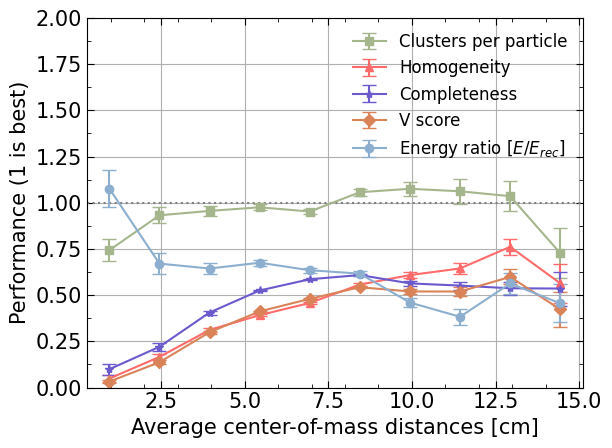

In [40]:
many = df_ma.Lnum_labels > 1
fig, ax = plt.subplots(1,1)
ax.axhline(1, color="grey", linestyle="dotted")
bins=10
plot_chunks(df_ma[many].Lcom_avg, df_ma[many].Lclusters_per_label, bins, "Clusters per particle", "s", "#a5b68dff", ax)
plot_chunks(df_ma[many].Lcom_avg, df_ma[many].Lhomogeneity_score, bins, "Homogeneity", "^", "#ff6b6bff", ax)
plot_chunks(df_ma[many].Lcom_avg, df_ma[many].Lcompleteness_score, bins, "Completeness", "*", "#6a5acdff", ax)
plot_chunks(df_ma[many].Lcom_avg, df_ma[many].Lv_score, bins, "V score", "D", "#da8359ff", ax)

plot_chunks(df_ma[many].Lcom_avg, df_ma[many].eng_cl_rec_avg / df_ma[many].energy, bins, "Energy ratio [$E/E_{rec}$]", "o", "#8cafcfff", ax)


#ax.set_title("Clustered many-particle events")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.125))
ax.set_ylim(0,2)
plot_ax(ax, x_label="Average center-of-mass distances [cm]", y_label="Performance (1 is best)")
fig.savefig("many_performance_com_ma.pdf", bbox_inches="tight", transparent=True)

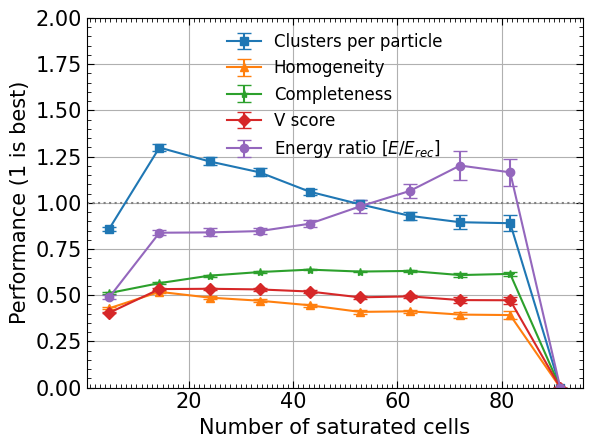

In [18]:
many = df_ma.Lnum_labels > 1
fig, ax = plt.subplots(1,1)
ax.axhline(1, color="grey", linestyle="dotted")
bins=10
plot_chunks(df_ma[many].Lnum_saturated_cells, df_ma[many].Lclusters_per_label, bins, "Clusters per particle", "s", ax)
plot_chunks(df_ma[many].Lnum_saturated_cells, df_ma[many].Lhomogeneity_score, bins, "Homogeneity", "^", ax)
plot_chunks(df_ma[many].Lnum_saturated_cells, df_ma[many].Lcompleteness_score, bins, "Completeness", "*", ax)
plot_chunks(df_ma[many].Lnum_saturated_cells, df_ma[many].Lv_score, bins, "V score", "D", ax)

plot_chunks(df_ma[many].Lnum_saturated_cells, df_ma[many].eng_cl_rec_avg / df_ma[many].energy, bins, "Energy ratio [$E/E_{rec}$]", "o", ax)


#ax.set_title("Clustered many-particle events")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(0,2)
plot_ax(ax, x_label="Number of saturated cells", y_label="Performance (1 is best)")
fig.savefig("many_performance_sat_ma.pdf", bbox_inches="tight", transparent=True)

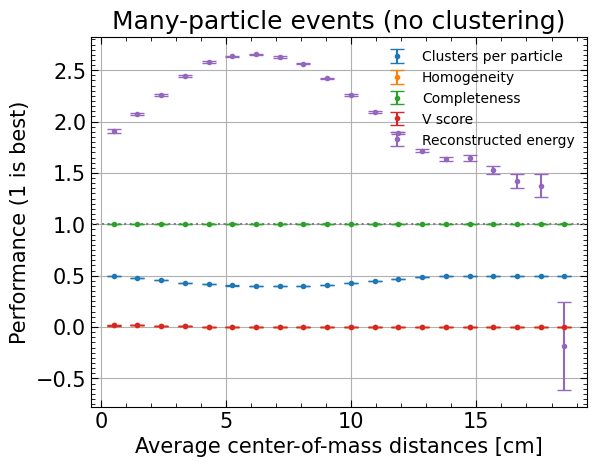

In [175]:
many = df_null.Lnum_labels > 1
fig, ax = plt.subplots(1,1)
ax.axhline(1, color="grey", linestyle="dotted")
plot_chunks(df_null[many].Lcom_avg, df_null[many].Lclusters_per_label, 20, "Clusters per particle", ax)
plot_chunks(df_null[many].Lcom_avg, df_null[many].Lhomogeneity_score, 20, "Homogeneity", ax)
plot_chunks(df_null[many].Lcom_avg, df_null[many].Lcompleteness_score, 20, "Completeness", ax)
plot_chunks(df_null[many].Lcom_avg, df_null[many].Lv_score, 20, "V score", ax)

plot_chunks(df_null[many].Lcom_avg, df_null[many].eng_cl_rec_avg / df_null[many].energy, 20, "Reconstructed energy", ax)


ax.set_title("Many-particle events (no clustering)")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plot_ax(ax, x_label="Average center-of-mass distances [cm]", y_label="Performance (1 is best)")
fig.savefig("many_performance_com_null.pdf", bbox_inches="tight", transparent=True)

In [116]:
def lst_len(lst):
    return len(lst)

def eng_avg(engs):
    return np.array(engs).mean().astype(int)

df["energy"] = df.Lenergies.apply(eng_avg)

# What do I want

- Homogeneity
- completeness
- v_score
- particles per label

as functions of

- Center-of-mass
- Energy
- Saturated cells
- Number of labels

In [124]:
df

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,Lcluster_sums,energy
0,"[[-4.509516340751861, 3.0383975001125454]]",2.000000,0.000000,1.000000,0.000000,-1.000000,23494.0,1.0,1.0,[350.0],"[13597.0, 6661.0]",350
1,"[[-6.3023217813856025, 0.02722564515785644]]",2.000000,0.000000,1.000000,0.000000,-1.000000,77766.0,1.0,7.0,[350.0],"[67395.0, 1657.0]",350
2,"[[0.8183251463982363, 2.4213109898164835]]",3.000000,0.000000,1.000000,0.000000,-1.000000,86063.0,1.0,4.0,[350.0],"[74306.0, 1376.0, 1103.0]",350
3,"[[-3.3581115339969596, -4.672998570954047]]",1.000000,0.000000,1.000000,0.000000,-1.000000,81320.0,1.0,5.0,[350.0],[72929.0],350
4,"[[-2.6121692604904014, -1.3380434027806964]]",1.000000,0.000000,1.000000,0.000000,-1.000000,45723.0,1.0,3.0,[350.0],[39198.0],350
...,...,...,...,...,...,...,...,...,...,...,...,...
230885,"[[-3.7299200850052325, 3.970042942876956], [-1...",0.000000,0.000000,0.000000,1.000000,4.172385,8983.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[],10
230886,"[[-3.7299200850052325, 3.970042942876956], [-4...",0.333333,0.020573,0.011182,0.128466,8.939041,8764.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[1612.0],10
230887,"[[-3.7299200850052325, 3.970042942876956], [-4...",0.333333,0.022759,0.012380,0.140811,6.530339,9360.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[1612.0],10
230888,"[[-3.7299200850052325, 3.970042942876956], [5....",0.000000,0.000000,0.000000,1.000000,6.697166,10579.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[],10


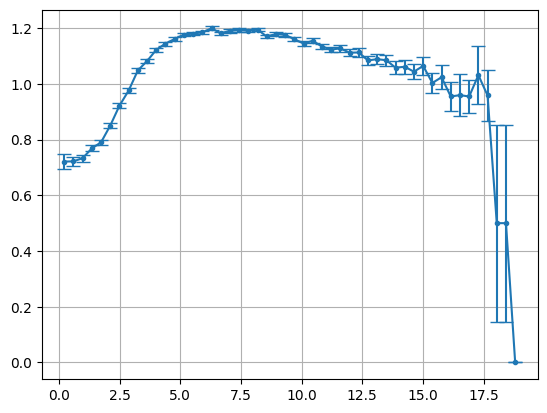

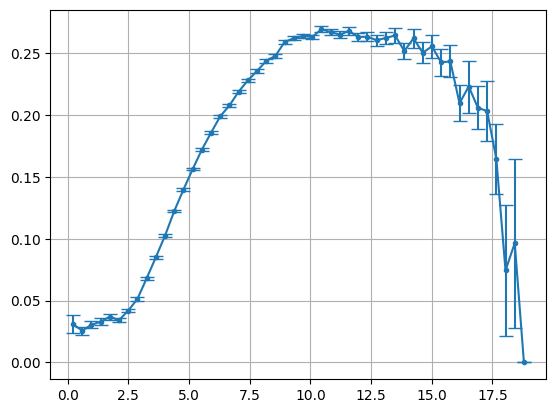

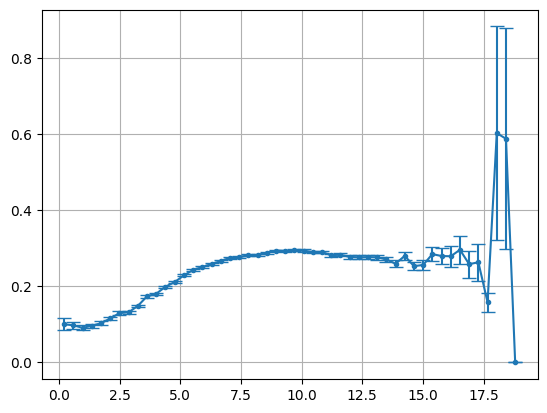

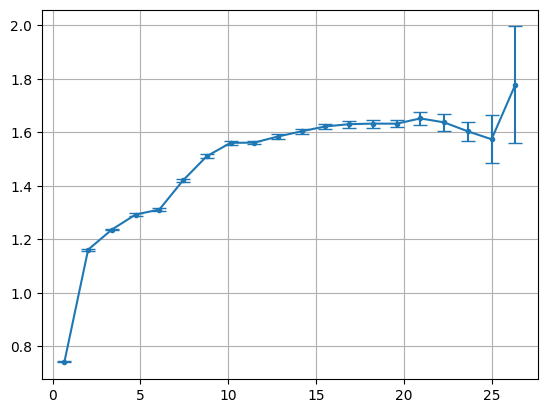

In [125]:
many = df.Lnum_labels > 1

df[many].Lcom_avg
df[many].Lclusters_per_label

plot_chunks(df[many].Lcom_avg, df[many].Lclusters_per_label, 50)
plot_chunks(df[many].Lcom_avg, df[many].Lhomogeneity_score, 50)
plot_chunks(df[many].Lcom_avg, df[many].Lcompleteness_score, 50)
plot_chunks(df[many].Lnum_saturated_cells, df[many].Lclusters_per_label, 20)

In [98]:
df[many][["energy", "Lclusters_per_label"]].groupby("energy").mean()

,Lclusters_per_label
energy,
10,0.102893
20,0.513090
40,0.967259
60,1.172478
80,1.131282
100,1.209855
150,1.319093
200,1.261839
250,1.508321


In [101]:
single = df.Lnum_labels == 1
df[single][["energy", "Lclusters_per_label"]].groupby("energy").mean()

,Lclusters_per_label
energy,
10,0.149
20,0.564
40,0.988
60,1.122
80,1.181
100,1.197
150,1.300
200,1.336
250,1.376


In [102]:
two = df.Lnum_labels == 2
df[two][["energy", "Lclusters_per_label"]].groupby("energy").mean()

,Lclusters_per_label
energy,
10,0.08565
20,0.49420
40,0.97545
60,1.21255
80,1.13600
100,1.23170
150,1.34290
200,1.24015
250,1.54210


In [103]:
three = df.Lnum_labels == 3
df[three][["energy", "Lclusters_per_label"]].groupby("energy").mean()

,Lclusters_per_label
energy,
10,0.120153
20,0.531999
40,0.959059
60,1.132366
80,1.126560
100,1.187988
150,1.295262
200,1.283550
250,1.474508


In [73]:
df[many]

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,adsf,energy
11000,"[[-4.509516340751861, 3.0383975001125454], [-6...",2.000000,0.028872,0.036657,0.023815,3.504470,101260.0,2.0,8.0,"[350.0, 350.0, 350.0]",230890,350
11001,"[[-4.509516340751861, 3.0383975001125454], [0....",2.500000,0.128269,0.202520,0.093857,5.363459,109557.0,2.0,5.0,"[350.0, 350.0, 350.0]",230890,350
11002,"[[-4.509516340751861, 3.0383975001125454], [-3...",2.000000,0.229117,0.341489,0.172390,7.796882,104814.0,2.0,6.0,"[350.0, 350.0, 350.0]",230890,350
11003,"[[-4.509516340751861, 3.0383975001125454], [-2...",1.000000,0.075953,0.087911,0.066858,4.770027,69217.0,2.0,4.0,"[350.0, 350.0, 350.0]",230890,350
11004,"[[-4.509516340751861, 3.0383975001125454], [3....",1.500000,0.150679,0.162714,0.140302,8.103789,44323.0,2.0,2.0,"[350.0, 350.0, 350.0]",230890,350
...,...,...,...,...,...,...,...,...,...,...,...,...
230885,"[[-3.7299200850052325, 3.970042942876956], [-1...",0.000000,0.000000,0.000000,1.000000,4.172385,8983.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",230890,10
230886,"[[-3.7299200850052325, 3.970042942876956], [-4...",0.333333,0.020573,0.011182,0.128466,8.939041,8764.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",230890,10
230887,"[[-3.7299200850052325, 3.970042942876956], [-4...",0.333333,0.022759,0.012380,0.140811,6.530339,9360.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",230890,10
230888,"[[-3.7299200850052325, 3.970042942876956], [5....",0.000000,0.000000,0.000000,1.000000,6.697166,10579.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",230890,10


# Linearity

In [126]:
df

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,Lcluster_sums,energy
0,"[[-4.509516340751861, 3.0383975001125454]]",2.000000,0.000000,1.000000,0.000000,-1.000000,23494.0,1.0,1.0,[350.0],"[13597.0, 6661.0]",350
1,"[[-6.3023217813856025, 0.02722564515785644]]",2.000000,0.000000,1.000000,0.000000,-1.000000,77766.0,1.0,7.0,[350.0],"[67395.0, 1657.0]",350
2,"[[0.8183251463982363, 2.4213109898164835]]",3.000000,0.000000,1.000000,0.000000,-1.000000,86063.0,1.0,4.0,[350.0],"[74306.0, 1376.0, 1103.0]",350
3,"[[-3.3581115339969596, -4.672998570954047]]",1.000000,0.000000,1.000000,0.000000,-1.000000,81320.0,1.0,5.0,[350.0],[72929.0],350
4,"[[-2.6121692604904014, -1.3380434027806964]]",1.000000,0.000000,1.000000,0.000000,-1.000000,45723.0,1.0,3.0,[350.0],[39198.0],350
...,...,...,...,...,...,...,...,...,...,...,...,...
230885,"[[-3.7299200850052325, 3.970042942876956], [-1...",0.000000,0.000000,0.000000,1.000000,4.172385,8983.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[],10
230886,"[[-3.7299200850052325, 3.970042942876956], [-4...",0.333333,0.020573,0.011182,0.128466,8.939041,8764.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[1612.0],10
230887,"[[-3.7299200850052325, 3.970042942876956], [-4...",0.333333,0.022759,0.012380,0.140811,6.530339,9360.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[1612.0],10
230888,"[[-3.7299200850052325, 3.970042942876956], [5....",0.000000,0.000000,0.000000,1.000000,6.697166,10579.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[],10


In [117]:
en350 = (df.energy == 350) & (df.Lnum_labels == 1)
en300 = (df.energy == 300) & (df.Lnum_labels == 1)
en250 = (df.energy == 250) & (df.Lnum_labels == 1)
en200 = (df.energy == 200) & (df.Lnum_labels == 1)
en150 = (df.energy == 150) & (df.Lnum_labels == 1)
en100 = (df.energy == 100) & (df.Lnum_labels == 1)
en80 = (df.energy == 80) & (df.Lnum_labels == 1)
en60 = (df.energy == 60) & (df.Lnum_labels == 1)
en40 = (df.energy == 40) & (df.Lnum_labels == 1)
en20 = (df.energy == 20) & (df.Lnum_labels == 1)
en10 = (df.energy == 10) & (df.Lnum_labels == 1)
enmasks = [en350, en300, en250, en200, en150, en100, en80, en60, en40, en20, en10]

In [118]:
def rices_rule(arr):
    """
    Rule for choosing bin size I want to try.
    Cube root times 2.
    https://www.statisticshowto.com/choose-bin-sizes-statistics/#choose
    """
    return np.round((len(arr))**(1/3)*2, 0).astype(int)

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def lin(x,m,b):
    return m*x + b

def fit_gaussian(arr):
    """
    Gaussian fit using iminuit and a least squares loss function.
    """

    def least_squares(A, mu, sigma):
        predicted = gaussian(x_data, A, mu, sigma)
        return np.sum((y_data - predicted)**2)
    
    Nbins = rices_rule(arr)
    hist, bins = np.histogram(arr, bins=Nbins)
    bin_centers = bins[:-1] + np.diff(bins) / 2
    x_data = bin_centers
    y_data = hist
    m = Minuit(least_squares, A=y_data.max(), mu=arr.mean(), sigma=arr.std())
    m.migrad()  # Perform the minimization
    m.hesse()   # Estimate the uncertainties

    fit_amplitude = m.values['A']
    fit_mean = m.values['mu']
    fit_sigma = m.values['sigma']
    
    return (fit_amplitude, fit_mean, fit_sigma)

def fit_gaussian_all(frame, masks):
    fits = [None]*len(masks)
    for i,m in enumerate(masks):
        energy = frame[m].energy.mean().astype(int)
        fits[i] = list(fit_gaussian(frame[m].Ladc_sum))
        fits[i].append(energy)
    return np.array(fits)

def linear_fit(x,y):
    def least_squares(m, b):
        predicted = lin(x_data, m, b)
        return np.sum((y_data - predicted)**2)
    x_data = x
    y_data = y
    m_guess = y[0] - y[1]/(x[0] - x[1])
    m = Minuit(least_squares, m=m_guess, b=0)
    m.migrad()  # Perform the minimization
    m.hesse()   # Estimate the uncertainties
    fit_slope = m.values['m']
    fit_intersection = m.values['b']
    return fit_slope, fit_intersection

def lin_inv(y, m, b):
    return (y-b)/m

g_fit = fit_gaussian_all(df, enmasks)
l_fit = linear_fit(g_fit[:,3], g_fit[:,1])

In [119]:
df["m"] = l_fit[0]
df["b"] = l_fit[1]

In [135]:
df

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,Lcluster_sums,energy,m,b,eng_cl_rec_avg,eng_adc_rec_avg
0,"[[-4.509516340751861, 3.0383975001125454]]",2.000000,0.000000,1.000000,0.00000,-1.000000,23494.0,1.0,1.0,[350.0],"[13597.0, 6661.0]",350,231.230913,6071.151242,17.548903,75.348268
1,"[[-6.3023217813856025, 0.02722564515785644]]",2.000000,0.000000,1.000000,0.00000,-1.000000,77766.0,1.0,7.0,[350.0],"[67395.0, 1657.0]",350,231.230913,6071.151242,123.058151,310.057370
2,"[[0.8183251463982363, 2.4213109898164835]]",3.000000,0.000000,1.000000,0.00000,-1.000000,86063.0,1.0,4.0,[350.0],"[74306.0, 1376.0, 1103.0]",350,231.230913,6071.151242,84.434423,345.939250
3,"[[-3.3581115339969596, -4.672998570954047]]",1.000000,0.000000,1.000000,0.00000,-1.000000,81320.0,1.0,5.0,[350.0],[72929.0],350,231.230913,6071.151242,289.138886,325.427287
4,"[[-2.6121692604904014, -1.3380434027806964]]",1.000000,0.000000,1.000000,0.00000,-1.000000,45723.0,1.0,3.0,[350.0],[39198.0],350,231.230913,6071.151242,143.263062,171.481608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230885,"[[-3.7299200850052325, 3.970042942876956], [-1...",0.000000,0.000000,0.000000,1.00000,4.172385,8983.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[],10,231.230913,6071.151242,0.000000,12.592818
230886,"[[-3.7299200850052325, 3.970042942876956], [-4...",0.333333,0.214755,0.155090,0.34903,8.939041,8764.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[1612.0],10,231.230913,6071.151242,-19.284408,11.645713
230887,"[[-3.7299200850052325, 3.970042942876956], [-4...",0.333333,0.220448,0.156439,0.37311,6.530339,9360.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[1612.0],10,231.230913,6071.151242,-19.284408,14.223223
230888,"[[-3.7299200850052325, 3.970042942876956], [5....",0.000000,0.000000,0.000000,1.00000,6.697166,10579.0,3.0,0.0,"[10.0, 10.0, 10.0, 10.0]",[],10,231.230913,6071.151242,0.000000,19.495009


In [124]:
def eng_adc_rec_avg(cols):
    adc = cols.Ladc_sum
    m = cols.m
    b = cols.b
    return lin_inv(adc, m, b)

def eng_cl_rec_avg(cols):
    cluster_sums = cols.Lcluster_sums
    if len(cluster_sums) == 0:
        return 0
    m = cols.m
    b = cols.b
    labels = cols.Lnum_labels
    cluster_eng = [lin_inv(c, m, b) for c in cluster_sums]
    return np.mean(cluster_eng)


df["eng_adc_rec_avg"] = df.apply(eng_adc_rec_avg, axis=1)
df["eng_cl_rec_avg"] = df.apply(eng_cl_rec_avg, axis=1)


In [154]:
(250 - df[(df.energy == 250) & (single)].eng_cl_rec_avg.mean())**2

np.float64(8794.206009203277)

Hmm...

In [179]:
np.sqrt(((250 - df[(df.energy == 250) & (single)].eng_cl_rec_avg)**2).sum()/len(df[(df.energy == 250) & (single)]))

np.float64(121.48821283128231)

In [180]:
np.sqrt(((250 - df[(df.energy == 250) & (single)].eng_adc_rec_avg)**2).sum()/len(df[(df.energy == 250) & (single)]))

np.float64(87.52342460772554)

In [181]:
np.sqrt(((250 - df[(df.energy == 250) & (many)].eng_cl_rec_avg)**2).sum()/len(df[(df.energy == 250) & (many)]))

np.float64(123.59192819590126)

In [182]:
np.sqrt(((250 - df[(df.energy == 250) & (many)].eng_adc_rec_avg)**2).sum()/len(df[(df.energy == 250) & (many)]))

np.float64(416.402632152842)

Ok, does look like RMSE difference is larger for many particles than single particles.

In [155]:
(250 - df[(df.energy == 250) & (single)].eng_adc_rec_avg.mean())**2

np.float64(259.71488575018446)

In [156]:
(250 - df[(df.energy == 250)].eng_cl_rec_avg.mean())**2

np.float64(7896.720610290789)

In [157]:
(250 - df[(df.energy == 250)].eng_adc_rec_avg.mean())**2

np.float64(127645.71014461144)

In [159]:
df[single].Lclusters_per_label.mean()

np.float64(1.0994545454545455)

In [162]:
df[en350].Lclusters_per_label.mean()

np.float64(1.461)

In [163]:
df[en350].Lnum_labels.mean()

np.float64(1.0)

In [169]:
df[(df.energy == 350) & (df.Lnum_labels > 1)].Lnum_labels.mean()

np.float64(2.4997498749374687)

In [170]:
df[(df.energy == 350) & (df.Lnum_labels > 1)].Lclusters_per_label.mean()

np.float64(1.6696431549107886)

In [171]:
df[(df.energy == 350) & (df.Lnum_labels > 1)]

,Lcom,Lclusters_per_label,Lv_score,Lhomogeneity_score,Lcompleteness_score,Lcom_avg,Ladc_sum,Lnum_labels,Lnum_saturated_cells,Lenergies,Lcluster_sums,energy,m,b,eng_adc_rec_avg,eng_cl_rec_avg
11000,"[[-4.509516340751861, 3.0383975001125454], [-6...",2.000000,0.028872,0.036657,0.023815,3.504470,101260.0,2.0,8.0,"[350.0, 350.0, 350.0]","[83150.0, 4441.0, 4275.0, 1657.0]",350,231.230913,6071.151242,411.661431,74.858498
11001,"[[-4.509516340751861, 3.0383975001125454], [0....",2.500000,0.128269,0.202520,0.093857,5.363459,109557.0,2.0,5.0,"[350.0, 350.0, 350.0]","[79607.0, 11445.0, 8140.0, 1148.0, 1107.0]",350,231.230913,6071.151242,447.543312,61.489394
11002,"[[-4.509516340751861, 3.0383975001125454], [-3...",2.000000,0.229117,0.341489,0.172390,7.796882,104814.0,2.0,6.0,"[350.0, 350.0, 350.0]","[16266.0, 71928.0, 7648.0, 1074.0]",350,231.230913,6071.151242,427.031349,78.526908
11003,"[[-4.509516340751861, 3.0383975001125454], [-2...",1.000000,0.075953,0.087911,0.066858,4.770027,69217.0,2.0,4.0,"[350.0, 350.0, 350.0]","[52534.0, 9889.0]",350,231.230913,6071.151242,273.085669,108.723995
11004,"[[-4.509516340751861, 3.0383975001125454], [3....",1.500000,0.150679,0.162714,0.140302,8.103789,44323.0,2.0,2.0,"[350.0, 350.0, 350.0]","[15024.0, 15924.0, 6692.0]",350,231.230913,6071.151242,165.427054,28.004540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130985,"[[-3.1822594122634333, 1.0011651090952887], [-...",2.000000,0.059239,0.049001,0.074886,3.129982,267223.0,3.0,20.0,"[350.0, 350.0, 350.0, 350.0]","[243082.0, 10433.0, 1148.0, 2048.0, 1004.0, 27...",350,231.230913,6071.151242,1129.398509,161.461321
130986,"[[-3.1822594122634333, 1.0011651090952887], [4...",3.333333,0.260576,0.291599,0.235519,7.454752,245364.0,3.0,17.0,"[350.0, 350.0, 350.0, 350.0]","[148241.0, 71251.0, 4189.0, 4076.0, 4817.0, 12...",350,231.230913,6071.151242,1034.865301,77.203988
130987,"[[-3.1822594122634333, 1.0011651090952887], [-...",3.000000,0.376380,0.488486,0.306125,7.572485,259638.0,3.0,16.0,"[350.0, 350.0, 350.0, 350.0]","[101403.0, 4566.0, 70793.0, 46761.0, 20360.0, ...",350,231.230913,6071.151242,1096.595802,95.409503
130988,"[[-3.1822594122634333, 1.0011651090952887], [-...",2.666667,0.271049,0.302582,0.245468,6.397053,291494.0,3.0,19.0,"[350.0, 350.0, 350.0, 350.0]","[130343.0, 83855.0, 54214.0, 4735.0, 4630.0, 6...",350,231.230913,6071.151242,1234.362848,129.413811
